In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.95

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "exoverstation," + \
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   torino
   2   palermo
   3   catanzaro
   4   ferrara
   5   bologna
   6   brindisi
   7   nuoro
   8   forli
   9   caserta
   10   asti
   11   rimini
   12   verona
   13   pavia
   14   ascoli_piceno
   15   verbania
   16   frosinone
   17   chieti
   18   rieti
   19   lodi
   20   alessandria
   21   trapani
   22   padova
   23   lecco
   24   pescara
   25   salerno
   26   biella
   27   siracusa
   28   cosenza
   29   milano
   30   prato
   31   pisa
   32   cagliari
   33   massa
   34   napoli
   35   foggia
   36   trieste
   37   reggio_nell_emilia
   38   agrigento
   39   teramo
   40   cuneo
   41   modena
   42   benevento
   43   bergamo
   44   gorizia
   45   ragusa
   46   imperia
   47   grosseto
   48   parma
   49   bari
   50   catania
   51   brescia
   52   matera
   53   caltanissetta
   54   enna
   55   novara
   56   la_spezia
   57   mantova
   58   genova
   59   terni

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
            ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 torino
2 palermo
3 catanzaro
4 ferrara
5 bologna
6 brindisi
7 nuoro
8 forli
9 caserta
10 asti
11 rimini
12 verona
13 pavia
14 ascoli_piceno
15 verbania
16 frosinone
17 chieti
18 rieti
19 lodi
20 alessandria
21 trapani
22 padova
23 lecco
24 pescara
25 salerno
26 biella
27 siracusa
28 cosenza
29 milano
30 prato
31 pisa
32 cagliari
33 massa
34 napoli
35 foggia
36 trieste
37 reggio_nell_emilia
38 agrigento
39 teramo
40 cuneo
41 modena
42 benevento
43 bergamo
44 gorizia
45 ragusa
46 imperia
47 grosseto
48 parma
49 bari
50 catania
51 brescia
52 matera
53 caltanissetta
54 enna
55 novara
56 la_spezia
57 mantova
58 genova
59 terni
60 monza
61 siena
62 sassari
63 bat
64 lecce
65 vibo_valentia
66 latina
67 campobasso
68 varese
69 roma
70 venezia
71 vercelli
72 macerata
73 ancona
74 taranto
75 udine
76 piacenza
77 rovigo
78 pistoia
79 messina
80 fermo
81 sondrio
82 crotone
83 ravenna
84 oristano
85 viterbo
86 l_aquila
87 pordenone
88 potenza
89 arezzo
90 avellino
91 trento
92 como
93 reggio_di_c

In [4]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    #if len(highcorrelated[v1]) > 0:
    #    print(v1)
    #    for fntr in highcorrelated[v1]:
    #        print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

Training set average RMSE:  0.34961  0.02257 
    Test set average RMSE:  0.93600  0.09569 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.34557
                       R2:  0.94535


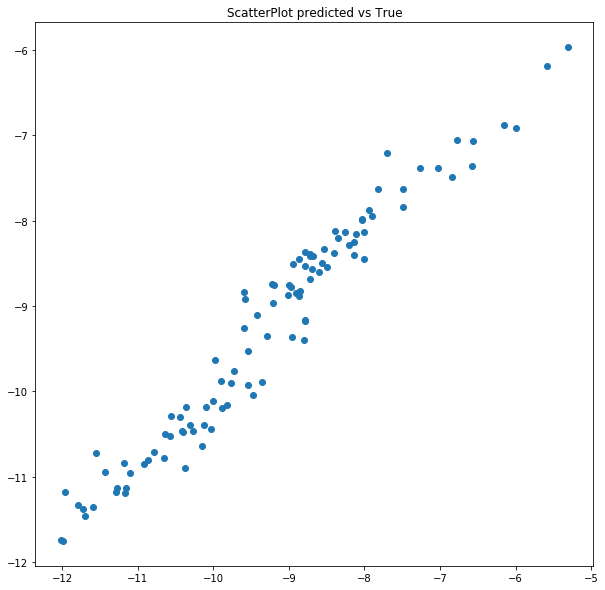

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02386
Feature:               commutersdensity, Score: 0.01954
Feature:                         depriv, Score: 0.02287
Feature:                            lat, Score: 0.63780
Feature:                 Ratio0200ver65, Score: 0.05221
Feature:           avg_wco_period1_2020, Score: 0.03482
Feature:          avg_wnh3_period1_2020, Score: 0.06634
Feature:           avg_wno_period1_2020, Score: 0.04330
Feature:           avg_wo3_period1_2020, Score: 0.04523
Feature:         avg_wpans_period1_2020, Score: 0.02891
Feature:          avg_wso2_period1_2020, Score: 0.02512


<Figure size 432x288 with 0 Axes>

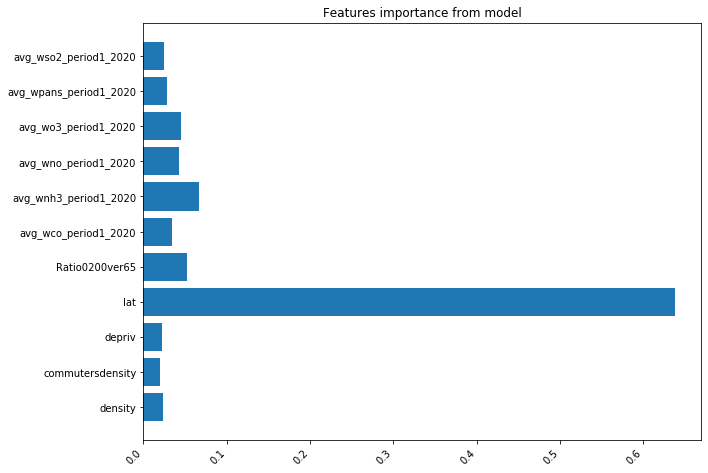

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04514 +/- 0.00342
Feature:               commutersdensity, Score: 0.03327 +/- 0.00410
Feature:                         depriv, Score: 0.04257 +/- 0.00423
Feature:                            lat, Score: 2.76248 +/- 0.34172
Feature:                 Ratio0200ver65, Score: 0.09086 +/- 0.01421
Feature:           avg_wco_period1_2020, Score: 0.09679 +/- 0.01397
Feature:          avg_wnh3_period1_2020, Score: 0.16855 +/- 0.02165
Feature:           avg_wno_period1_2020, Score: 0.10719 +/- 0.01558
Feature:           avg_wo3_period1_2020, Score: 0.10234 +/- 0.01252
Feature:         avg_wpans_period1_2020, Score: 0.04755 +/- 0.00677
Feature:          avg_wso2_period1_2020, Score: 0.05224 +/- 0.00739


<Figure size 432x288 with 0 Axes>

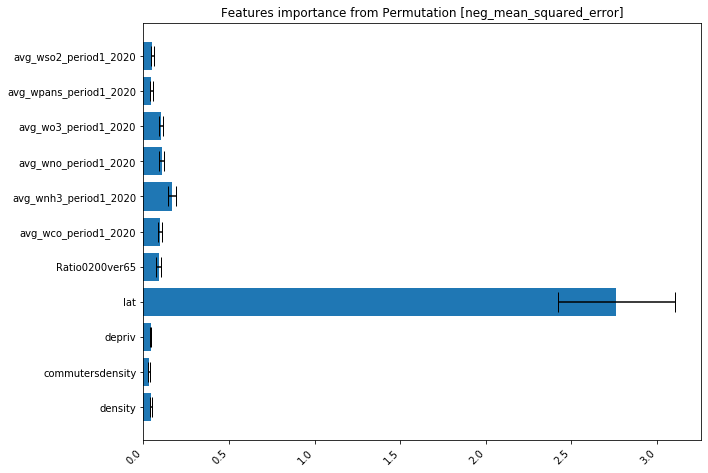

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02066 +/- 0.00156
Feature:               commutersdensity, Score: 0.01523 +/- 0.00187
Feature:                         depriv, Score: 0.01948 +/- 0.00193
Feature:                            lat, Score: 1.26415 +/- 0.15637
Feature:                 Ratio0200ver65, Score: 0.04158 +/- 0.00650
Feature:           avg_wco_period1_2020, Score: 0.04429 +/- 0.00639
Feature:          avg_wnh3_period1_2020, Score: 0.07713 +/- 0.00991
Feature:           avg_wno_period1_2020, Score: 0.04905 +/- 0.00713
Feature:           avg_wo3_period1_2020, Score: 0.04683 +/- 0.00573
Feature:         avg_wpans_period1_2020, Score: 0.02176 +/- 0.00310
Feature:          avg_wso2_period1_2020, Score: 0.02391 +/- 0.00338


<Figure size 432x288 with 0 Axes>

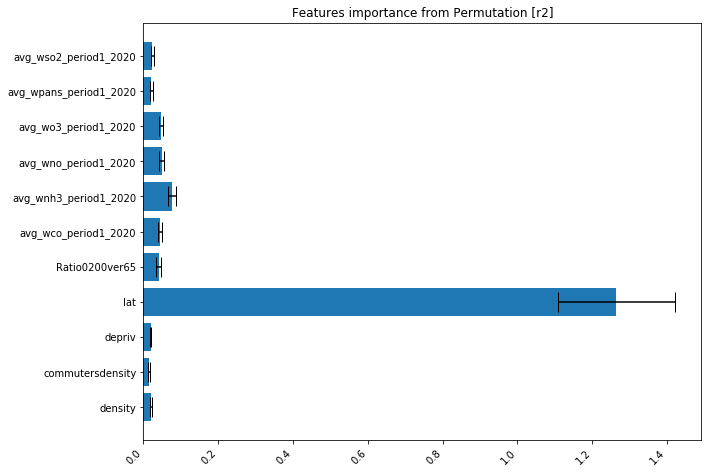

<Figure size 720x720 with 0 Axes>

((0.34960934441432767, 0.02257166866165344),
 (0.9359974753895712, 0.09569023379172069),
 0.34556723721743626,
 {'density': 0.012718917479957735,
  'commutersdensity': 0.009374781035452574,
  'depriv': 0.011994778432332237,
  'lat': 0.7783878902044145,
  'Ratio0200ver65': 0.025601293053119003,
  'avg_wco_period1_2020': 0.02727198728373459,
  'avg_wnh3_period1_2020': 0.04749144936849573,
  'avg_wno_period1_2020': 0.030203815333270642,
  'avg_wo3_period1_2020': 0.028835678952244998,
  'avg_wpans_period1_2020': 0.013399113569651844,
  'avg_wso2_period1_2020': 0.014720295287326136},
 {'density': 0.012718917479957756,
  'commutersdensity': 0.009374781035452591,
  'depriv': 0.011994778432332251,
  'lat': 0.7783878902044143,
  'Ratio0200ver65': 0.025601293053119038,
  'avg_wco_period1_2020': 0.027271987283734617,
  'avg_wnh3_period1_2020': 0.04749144936849575,
  'avg_wno_period1_2020': 0.030203815333270666,
  'avg_wo3_period1_2020': 0.02883567895224503,
  'avg_wpans_period1_2020': 0.013399113

<Figure size 432x288 with 0 Axes>

In [5]:
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures", showplot=True)

In [6]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.11941671543809185
2  of  1200 MSE:  0.10829410806097234
3  of  1200 MSE:  0.1733137496047756
4  of  1200 MSE:  0.21280336628058566
5  of  1200 MSE:  0.3996005769470249
6  of  1200 MSE:  0.4801089479710902
7  of  1200 MSE:  0.5723407792971108
8  of  1200 MSE:  0.6827401184892877
9  of  1200 MSE:  0.16790166157109782
10  of  1200 MSE:  0.1869249625273589
11  of  1200 MSE:  0.19200062202659587
12  of  1200 MSE:  0.2391677660928671
13  of  1200 MSE:  0.3996005769470249
14  of  1200 MSE:  0.4801089479710902
15  of  1200 MSE:  0.5723407792971108
16  of  1200 MSE:  0.6827401184892877
17  of  1200 MSE:  0.2665998411150425
18  of  1200 MSE:  0.3141524403700992
19  of  1200 MSE:  0.29192789644040584
20  of  1200 MSE:  0.35761231452381065
21  of  1200 MSE:  0.3996005769470249
22  of  1200 MSE:  0.4801089479710902
23  of  1200 MSE:  0.5723407792971108
24  of  1200 MSE:  0.6827401184892877
25  of  1200 MSE:  0.36915172551752234
26  of  1200 MSE:  0.42711729691048106
27  of  1200

{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300,
 'random_state': 1}
Training set average RMSE:  0.33987  0.02010 
    Test set average RMSE:  0.93996  0.09773 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.32486
                       R2:  0.95171


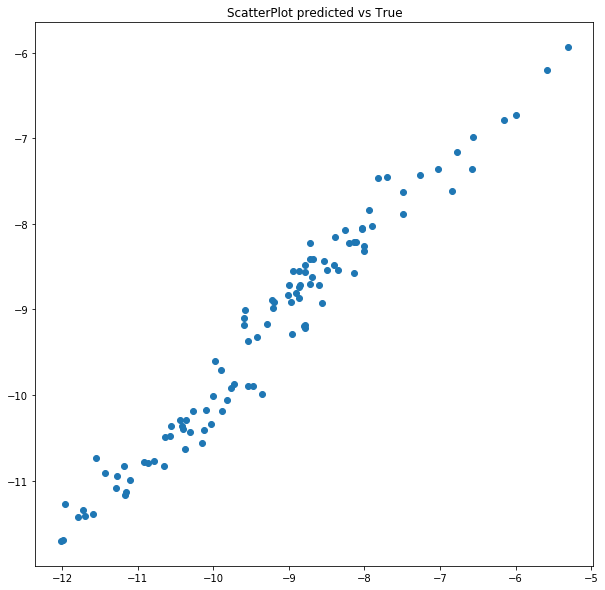

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03438
Feature:               commutersdensity, Score: 0.16311
Feature:                         depriv, Score: 0.07108
Feature:                            lat, Score: 0.24091
Feature:                 Ratio0200ver65, Score: 0.05097
Feature:           avg_wco_period1_2020, Score: 0.11935
Feature:          avg_wnh3_period1_2020, Score: 0.08385
Feature:           avg_wno_period1_2020, Score: 0.09839
Feature:           avg_wo3_period1_2020, Score: 0.06910
Feature:         avg_wpans_period1_2020, Score: 0.03433
Feature:          avg_wso2_period1_2020, Score: 0.03454


<Figure size 432x288 with 0 Axes>

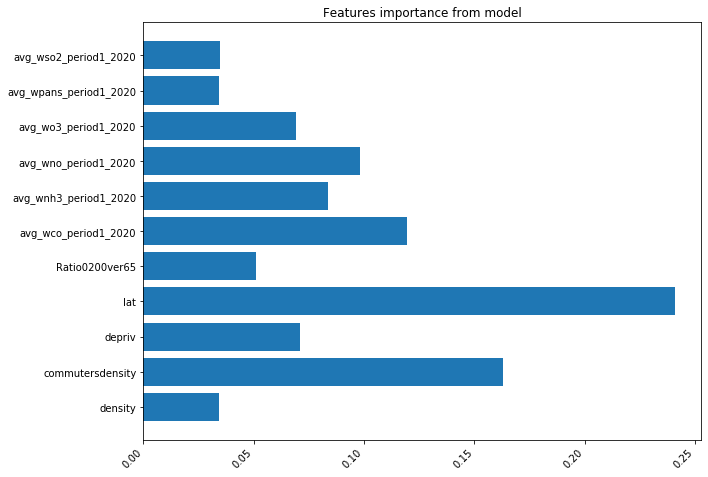

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.03880 +/- 0.00305
Feature:               commutersdensity, Score: 0.01966 +/- 0.00244
Feature:                         depriv, Score: 0.04068 +/- 0.00424
Feature:                            lat, Score: 2.79592 +/- 0.34417
Feature:                 Ratio0200ver65, Score: 0.09887 +/- 0.01812
Feature:           avg_wco_period1_2020, Score: 0.07768 +/- 0.01109
Feature:          avg_wnh3_period1_2020, Score: 0.16624 +/- 0.02183
Feature:           avg_wno_period1_2020, Score: 0.11692 +/- 0.01796
Feature:           avg_wo3_period1_2020, Score: 0.09480 +/- 0.01085
Feature:         avg_wpans_period1_2020, Score: 0.05917 +/- 0.00830
Feature:          avg_wso2_period1_2020, Score: 0.05550 +/- 0.00784


<Figure size 432x288 with 0 Axes>

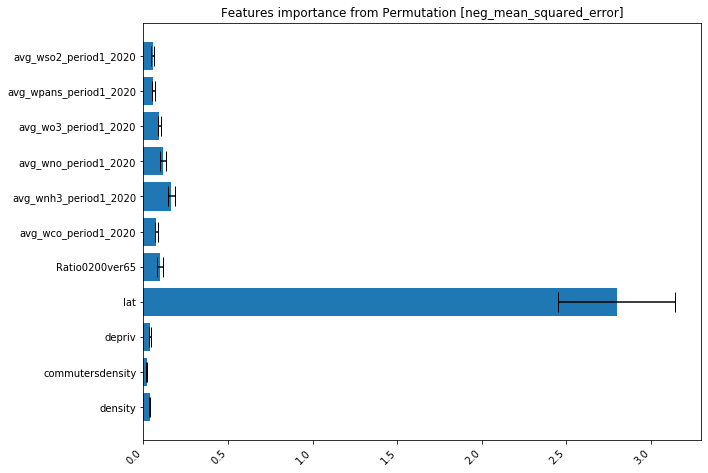

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.01776 +/- 0.00140
Feature:               commutersdensity, Score: 0.00900 +/- 0.00112
Feature:                         depriv, Score: 0.01862 +/- 0.00194
Feature:                            lat, Score: 1.27945 +/- 0.15750
Feature:                 Ratio0200ver65, Score: 0.04524 +/- 0.00829
Feature:           avg_wco_period1_2020, Score: 0.03555 +/- 0.00508
Feature:          avg_wnh3_period1_2020, Score: 0.07607 +/- 0.00999
Feature:           avg_wno_period1_2020, Score: 0.05350 +/- 0.00822
Feature:           avg_wo3_period1_2020, Score: 0.04338 +/- 0.00496
Feature:         avg_wpans_period1_2020, Score: 0.02708 +/- 0.00380
Feature:          avg_wso2_period1_2020, Score: 0.02540 +/- 0.00359


<Figure size 432x288 with 0 Axes>

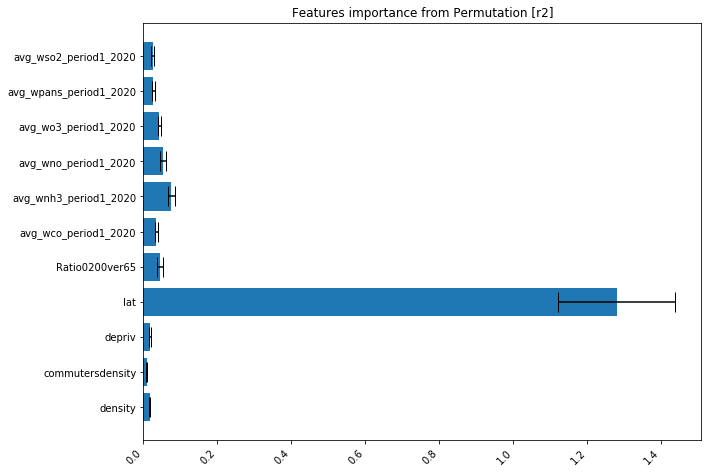

<Figure size 720x720 with 0 Axes>

((0.3398746272250127, 0.020097103045109605),
 (0.9399550057348585, 0.09772641857667588),
 0.32485734389355475,
 {'density': 0.010886688701271928,
  'commutersdensity': 0.0055169095248709795,
  'depriv': 0.01141419477378692,
  'lat': 0.784435520731632,
  'Ratio0200ver65': 0.027738640836315737,
  'avg_wco_period1_2020': 0.02179348060216215,
  'avg_wnh3_period1_2020': 0.04664032919235162,
  'avg_wno_period1_2020': 0.03280407431140512,
  'avg_wo3_period1_2020': 0.026598572398593718,
  'avg_wpans_period1_2020': 0.01660033003728078,
  'avg_wso2_period1_2020': 0.015571258890329162},
 {'density': 0.01088668870127193,
  'commutersdensity': 0.005516909524870977,
  'depriv': 0.011414194773786926,
  'lat': 0.7844355207316317,
  'Ratio0200ver65': 0.02773864083631574,
  'avg_wco_period1_2020': 0.021793480602162154,
  'avg_wnh3_period1_2020': 0.04664032919235162,
  'avg_wno_period1_2020': 0.03280407431140512,
  'avg_wo3_period1_2020': 0.026598572398593718,
  'avg_wpans_period1_2020': 0.01660033003728

<Figure size 432x288 with 0 Axes>

In [7]:
pprint(bestf)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures_opt", showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.37622  0.02647 
    Test set average RMSE:  1.04591  0.09812 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.36659
                       R2:  0.93850


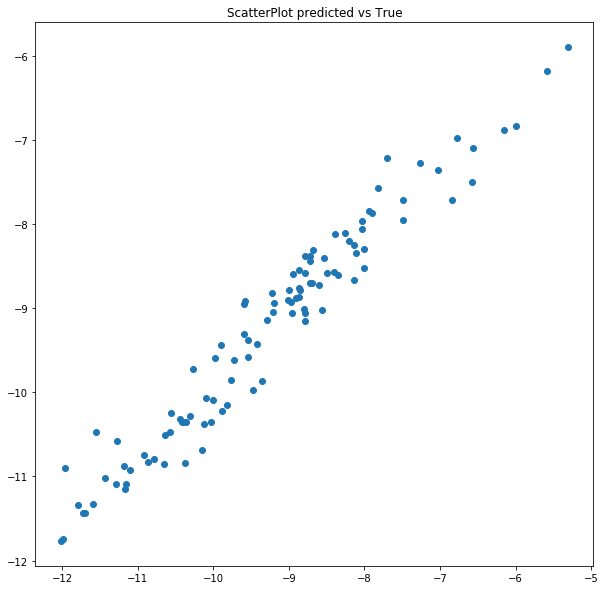

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02657
Feature:               commutersdensity, Score: 0.47269
Feature:                         depriv, Score: 0.03692
Feature:                 Ratio0200ver65, Score: 0.08858
Feature:           avg_wco_period1_2020, Score: 0.06263
Feature:          avg_wnh3_period1_2020, Score: 0.07513
Feature:           avg_wno_period1_2020, Score: 0.11151
Feature:           avg_wo3_period1_2020, Score: 0.05619
Feature:         avg_wpans_period1_2020, Score: 0.03471
Feature:          avg_wso2_period1_2020, Score: 0.03507


<Figure size 432x288 with 0 Axes>

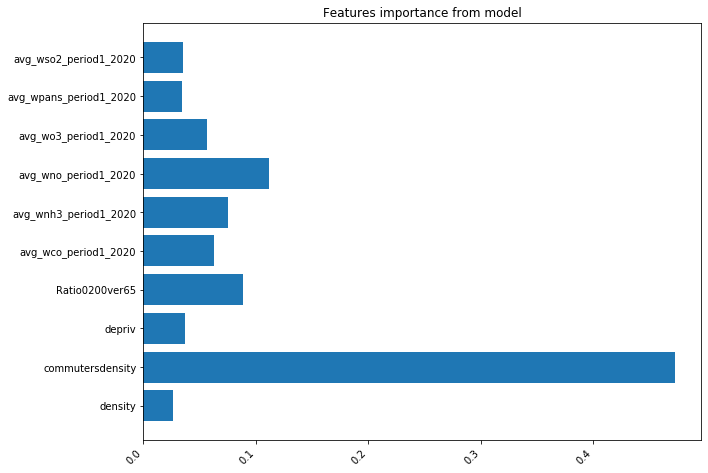

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04582 +/- 0.00456
Feature:               commutersdensity, Score: 1.62378 +/- 0.19362
Feature:                         depriv, Score: 0.05619 +/- 0.00788
Feature:                 Ratio0200ver65, Score: 0.22367 +/- 0.02747
Feature:           avg_wco_period1_2020, Score: 0.14337 +/- 0.01992
Feature:          avg_wnh3_period1_2020, Score: 0.17120 +/- 0.02254
Feature:           avg_wno_period1_2020, Score: 0.25655 +/- 0.03436
Feature:           avg_wo3_period1_2020, Score: 0.11524 +/- 0.01088
Feature:         avg_wpans_period1_2020, Score: 0.07229 +/- 0.01178
Feature:          avg_wso2_period1_2020, Score: 0.07527 +/- 0.00915


<Figure size 432x288 with 0 Axes>

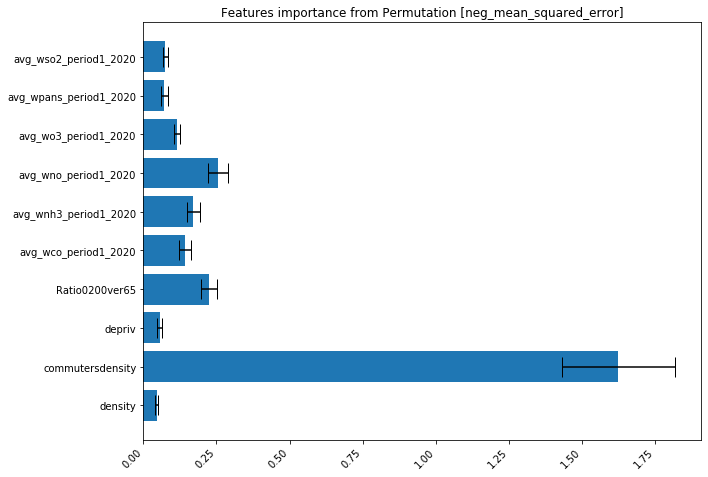

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02097 +/- 0.00208
Feature:               commutersdensity, Score: 0.74307 +/- 0.08860
Feature:                         depriv, Score: 0.02571 +/- 0.00360
Feature:                 Ratio0200ver65, Score: 0.10235 +/- 0.01257
Feature:           avg_wco_period1_2020, Score: 0.06561 +/- 0.00912
Feature:          avg_wnh3_period1_2020, Score: 0.07834 +/- 0.01032
Feature:           avg_wno_period1_2020, Score: 0.11740 +/- 0.01572
Feature:           avg_wo3_period1_2020, Score: 0.05274 +/- 0.00498
Feature:         avg_wpans_period1_2020, Score: 0.03308 +/- 0.00539
Feature:          avg_wso2_period1_2020, Score: 0.03444 +/- 0.00419


<Figure size 432x288 with 0 Axes>

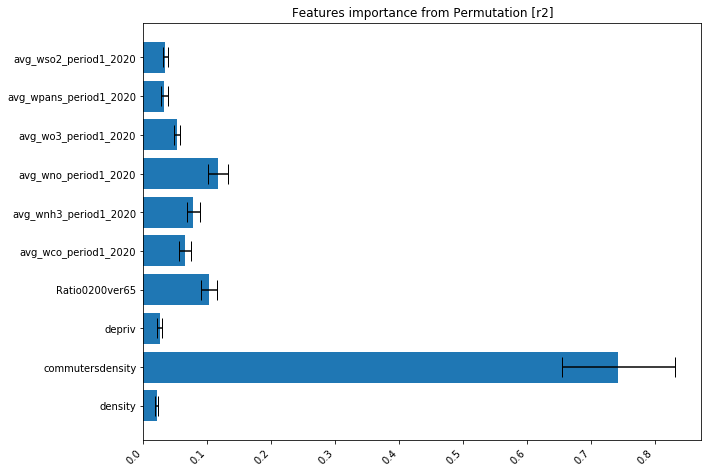

<Figure size 720x720 with 0 Axes>

((0.37621908733821263, 0.026472539921824086),
 (1.0459115601119917, 0.09811905621555812),
 0.36658838961888823,
 {'density': 0.016461843046768454,
  'commutersdensity': 0.583385469140318,
  'depriv': 0.020188567186647428,
  'Ratio0200ver65': 0.08035804578503235,
  'avg_wco_period1_2020': 0.051510937081386134,
  'avg_wnh3_period1_2020': 0.06150660759186442,
  'avg_wno_period1_2020': 0.09217157371085874,
  'avg_wo3_period1_2020': 0.04140361231965794,
  'avg_wpans_period1_2020': 0.025972167803965353,
  'avg_wso2_period1_2020': 0.027041176333500956},
 {'density': 0.016461843046768423,
  'commutersdensity': 0.5833854691403181,
  'depriv': 0.020188567186647403,
  'Ratio0200ver65': 0.08035804578503233,
  'avg_wco_period1_2020': 0.05151093708138613,
  'avg_wnh3_period1_2020': 0.061506607591864416,
  'avg_wno_period1_2020': 0.09217157371085871,
  'avg_wo3_period1_2020': 0.04140361231965792,
  'avg_wpans_period1_2020': 0.025972167803965336,
  'avg_wso2_period1_2020': 0.02704117633350093})

<Figure size 432x288 with 0 Axes>

In [8]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat", pout=sys.stdout, showplot=True)

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.1343870474033698
2  of  1200 MSE:  0.1357119001147795
3  of  1200 MSE:  0.20154995633719663
4  of  1200 MSE:  0.2518835262980276
5  of  1200 MSE:  0.47227081623682304
6  of  1200 MSE:  0.5466885729495632
7  of  1200 MSE:  0.7083615232161672
8  of  1200 MSE:  0.769143735350959
9  of  1200 MSE:  0.19639885010990982
10  of  1200 MSE:  0.2189160944301232
11  of  1200 MSE:  0.22736221982983612
12  of  1200 MSE:  0.28130040015547125
13  of  1200 MSE:  0.47227081623682304
14  of  1200 MSE:  0.5466885729495632
15  of  1200 MSE:  0.7083615232161672
16  of  1200 MSE:  0.769143735350959
17  of  1200 MSE:  0.3213281731299621
18  of  1200 MSE:  0.36958979785651486
19  of  1200 MSE:  0.3534021027602669
20  of  1200 MSE:  0.41798827718898035
21  of  1200 MSE:  0.47227081623682304
22  of  1200 MSE:  0.5466885729495632
23  of  1200 MSE:  0.7083615232161672
24  of  1200 MSE:  0.769143735350959
25  of  1200 MSE:  0.4492169433722189
26  of  1200 MSE:  0.5198606269307127
27  of  1200 MS

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_opt", showplot=True, optimisedparams=bestf)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat_nocommut", pout=sys.stdout, showplot=True)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_nocommut_opt", showplot=True, optimisedparams=bestf)